In [1]:
# useful starting lines
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
%load_ext autoreload
%autoreload 2

In [2]:
# import scripts
from proj1_helpers import *
from classifiers import *
from solver import *
from implementations import *
from dataprocessing import *
from plotting import * 

## Open data

In [3]:
# fetch train data
DATA_TRAIN_PATH = '../data/train.csv'
y, tX, ids, features = load_csv_data(DATA_TRAIN_PATH, sub_sample=False)
X = tX

In [4]:
print(features)
len(features)

['DER_mass_MMC', 'DER_mass_transverse_met_lep', 'DER_mass_vis', 'DER_pt_h', 'DER_deltaeta_jet_jet', 'DER_mass_jet_jet', 'DER_prodeta_jet_jet', 'DER_deltar_tau_lep', 'DER_pt_tot', 'DER_sum_pt', 'DER_pt_ratio_lep_tau', 'DER_met_phi_centrality', 'DER_lep_eta_centrality', 'PRI_tau_pt', 'PRI_tau_eta', 'PRI_tau_phi', 'PRI_lep_pt', 'PRI_lep_eta', 'PRI_lep_phi', 'PRI_met', 'PRI_met_phi', 'PRI_met_sumet', 'PRI_jet_num', 'PRI_jet_leading_pt', 'PRI_jet_leading_eta', 'PRI_jet_leading_phi', 'PRI_jet_subleading_pt', 'PRI_jet_subleading_eta', 'PRI_jet_subleading_phi', 'PRI_jet_all_pt']


30

## Feature engineering

In [5]:
# additive binarization of NaN values
feats_binarization = ['DER_mass_mmc','DER_deltaeta_jet_jet','PRI_jet_leading_pt']

# removing unnecessary features
feats_removal = ['DER_deltaeta_jet_jet','DER_mass_jet_jet','DER_prodeta_jet_jet','DER_lep_eta_centrality',
                 'PRI_jet_leading_pt','PRI_jet_leading_eta','PRI_jet_leading_phi','PRI_jet_subleading_pt',
                 'PRI_jet_subleading_eta','PRI_jet_subleading_phi']

### Handling case by case

* A - base
* B - base + offset + standardisation
* C - base + offset + standardisation + NaN to median
* D - base + offset + standardisation + additive binarization + removal of 10 NaN values + median for DER_mass_mmc
* E - base + offset + standardisation + NaN to median + outliers to caps
* F - Last model with bad optimization (without expansion)
* G - Last model with optimization

In [6]:
def cap_outliers(X):
    """
    Caps outliers
    
    :param X: data
    :return: capped data
    """
    
    lower = np.percentile(X, 5, axis=0)
    upper = np.percentile(X, 95, axis=0)
    
    for column in range(X.shape[1]):
        X[X[:,column] < lower[column], column] = lower[column]
        X[X[:,column] > upper[column], column] = upper[column]

    return X

In [7]:
def split_data(X, y=None):
    # features
    undef_feature_for = {
        'DER_deltaeta_jet_jet'   : [0, 1],
        'DER_mass_jet_jet'       : [0, 1],
        'DER_prodeta_jet_jet'    : [0, 1],
        'DER_lep_eta_centrality' : [0, 1],
        'PRI_jet_num'            : [0, 1, 2, 3],
        'PRI_jet_leading_pt'     : [0],
        'PRI_jet_leading_eta'    : [0],
        'PRI_jet_leading_phi'    : [0],
        'PRI_jet_subleading_pt'  : [0, 1],
        'PRI_jet_subleading_eta' : [0, 1],
        'PRI_jet_subleading_phi' : [0, 1],
        'PRI_jet_all_pt'         : [0]
    }

    jet_num_feature = "PRI_jet_num"
    jet_levels = 4

    features_split = []
    for jet in range(jet_levels):
        valid_features = [ f for f in features if not ((f in undef_feature_for) and (jet in undef_feature_for[f])) ]
        features_split.append(valid_features)
        
    # split data based on jet level (vertical split)
    split_indices = [
        X[:,features.index(jet_num_feature)] == i for i in range(jet_levels)
    ]
    X_split = [
        X[X[:,features.index(jet_num_feature)] == i,:] for i in range(jet_levels)
    ]
    if y is None:
        y_split = None
    else:
        y_split = [
            y[X[:,features.index(jet_num_feature)] == i] for i in range(jet_levels)
        ]

    # only keep relevant features (horizontal split)
    for i, X_ in enumerate(X_split):
        indices = [ features.index(feature) for feature in features_split[i] ]
        indices_bool = [ e in indices for e in range(len(features)) ]
        X_split[i] = X_[:,indices_bool]
        
    return split_indices, X_split, y_split

def build_poly_no_interaction(X, degree):
    result = X.copy()
    for d in range(2, degree+1):
        # faster than np.power()
        power = X.copy()
        for i in range(d - 1):
            power = power * X
            
        result = np.hstack((result, power))
        
    return result

def build_X(X, d_int, d_sq):
    """
    Expands X
    
    :param X: examples
    :param d_int: degree of integer powers
    :param d_sq: ceil of degree of half-powers (expansion will be up to d_sq - 0.5)
    
    """
    X_ = remove_NaN_features(X, 0.2)
    X_, mean_, std_ = standardize(X_)
    
    ints = []
    sqrts = []
    
    # build integer powers
    if d_int > 0:
        ints = build_poly_no_interaction(X_, d_int)
      
    # build half-powers (0.5, 1.5, 2.5, etc.)
    if d_sq > 0:
        sqrts = np.sqrt(np.abs(X_))
        if d_sq > 1:
            width = sqrts.shape[1]
            int_power = np.abs(build_poly_no_interaction(X_, d_sq - 1))
            
            half_power = sqrts.copy()
            for i in range(d_sq - 1):
                half_power = np.hstack((half_power, sqrts * int_power[:,(width*i):(width*(i+1))]))
                
            sqrts = np.hstack((sqrts, half_power))

    # concat
    X_ = np.hstack((ints, sqrts))
    return X_

In [8]:
# handling case A
X_A = X.copy()

# handling case B
X_B, _, _ = standardize(X_A)
X_B = np.c_[np.ones(len(y)), X_B]

# handling case C
X_C = X.copy()
X_C = replace_NaN_by_median(X_C)
X_C, _, _ = standardize(X_C)
X_C = np.c_[np.ones(len(y)), X_C]

# handling case D
X_D = X.copy()
features_D = features.copy()
X_D, features_D = binarize_undefined(X_D, features_D, feats_binarization)
X_D, features_D = remove_features(X_D, features_D, feats_removal)
X_D = replace_NaN_by_median(X_D) # only for DER_mass_mmc
X_D, _, _ = standardize(X_D)
X_D = np.c_[np.ones(len(y)), X_D]

# handling case E
X_E = X.copy()
X_E = cap_outliers(X_E)
X_E, _ , _ = standardize(X_E)
X_E = np.c_[np.ones(len(y)), X_E]

# handling case F
X_F = X.copy()
_, X_F_split, y_F_split = split_data(X_F, y)
lambda_F = 0.0001
X_F_split_poly = X_F_split.copy()

# handling case G
X_G_split_poly = [ build_X(X, 2, 1) for X in X_F_split ]

# handling case H
X_H_split_poly = [ build_X(X, 11, 3) for X in X_F_split ]
lambda_H = 1.46 * 1/pow(10,8)

## Fit and predict

In [9]:
# choice of classifier
classifier = LeastSquares()

accuracy_A = cross_validate(y, X_A, classifier, 0.7, 100)
accuracy_B = cross_validate(y, X_B, classifier, 0.7, 100)
accuracy_C = cross_validate(y, X_C, classifier, 0.7, 100)
accuracy_D = cross_validate(y, X_D, classifier, 0.7, 100)
accuracy_E = cross_validate(y, X_E, classifier, 0.7, 100)


accuracy_F = []
for i in range(len(X_F_split_poly)):
    classifier_F = LeastSquaresL2(lambda_F)
    acc = np.mean(cross_validate(y_F_split[i], X_F_split_poly[i], classifier_F, 0.7, 100))
    accuracy_F.append(acc)

accuracy_G = []
for i in range(len(X_G_split_poly)):
    classifier_G = LeastSquaresL2(lambda_F)
    acc = np.mean(cross_validate(y_F_split[i], X_G_split_poly[i], classifier_G, 0.7, 100))
    accuracy_G.append(acc)
    
    
accuracy_H = []
for i in range(len(X_G_split_poly)):
    classifier_H = LeastSquaresL2(lambda_H)
    acc = np.mean(cross_validate(y_F_split[i], X_H_split_poly[i], classifier_H, 0.7, 100))
    accuracy_H.append(acc)
    
accuracy = [list(accuracy_A), list(accuracy_B), list(accuracy_C), list(accuracy_D),
            list(accuracy_E), accuracy_F, accuracy_G, accuracy_H]

### Boxplot visualisation

In [10]:
accuracy_D = [a for a in accuracy_D if a > 0.7]

accuracy = [list(accuracy_A), list(accuracy_B), list(accuracy_C), list(accuracy_D),
            list(accuracy_E), accuracy_F, accuracy_G, accuracy_H]

acc = accuracy.copy()

acc = [[a * 100 for a in ac] for ac in acc]

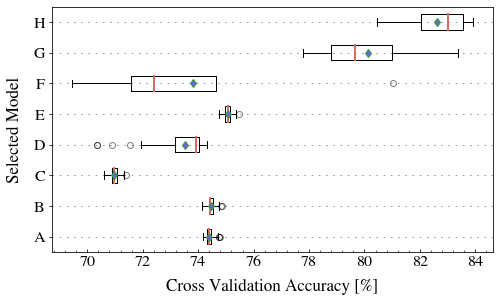

In [11]:
from plotting import *

boxplot_models(acc, save=True)

In [13]:
print("Mean: {}  Std Dev: {}".format(np.mean(accuracy_H), np.std(accuracy_H)))

Mean: 0.826025013984752  Std Dev: 0.013346226673448345
